In [ ]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# GraphRAG on Google Cloud


<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/gemini/reasoning-engine/tutorial_graph_rag.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo"><br> Run in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fgenerative-ai%2Fmain%2Fgemini%2Freasoning-engine%2Ftutorial_graph_rag.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo"><br> Run in Colab Enterprise
    </a>
  </td>      
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/reasoning-engine/tutorial_graph_rag.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/main/gemini/reasoning-engine/tutorial_graph_rag.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo"><br> Open in Vertex AI Workbench
    </a>
  </td>
</table>

| | |
|-|-|
|Author(s) | [Tristan Li](https://github.com/codingphun), Ashish Chauhan, [Smitha Venkat](https://github.com/smitha-google)

## Overview

[LangChain on Vertex AI](https://cloud.google.com/vertex-ai/generative-ai/docs/reasoning-engine/overview)
is a managed service that helps you to build and deploy LangChain apps to a managed Reasoning Engine runtime.

Instead of simply retrieving relevant text snippets based on keyword similarity, GraphRAG takes a more sophisticated, structured approach to Retrieval Augmented Generation. It involves creating a knowledge graph from the text, organizing it hierarchically, summarizing key concepts, and then using this structured information to enhance the accuracy and depth of responses.

## Objectives

In this tutorial, you will see a complete walkthrough of building a question-answering system using the GraphRAG method. You'll learn how to create a knowledge graph from scratch, store it efficiently in Spanner Graph, enhance search accuracy with embedding vectors in Spanner Vector Database, and finally, deploy a functional FAQ system with LangChain and Vertex AI Reasoning Engine.

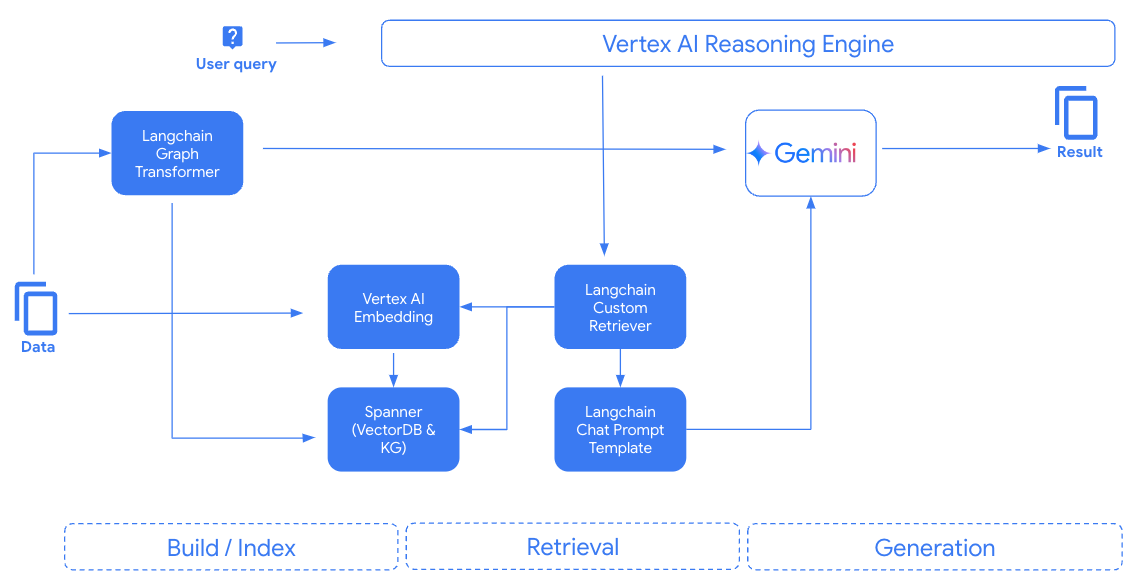

## Before you begin

1. In the Google Cloud console, on the project selector page, select or [create a Google Cloud project](https://cloud.google.com/resource-manager/docs/creating-managing-projects).
1. [Make sure that billing is enabled for your Google Cloud project](https://cloud.google.com/billing/docs/how-to/verify-billing-enabled#console).

### Required roles

To get the permissions that you need to complete the tutorial, ask your administrator to grant you the [Owner](https://cloud.google.com/iam/docs/understanding-roles#owner) (`roles/owner`) IAM role on your project. For more information about granting roles, see [Manage access](https://cloud.google.com/iam/docs/granting-changing-revoking-access).


## Getting Started

### Install Python Libraries

In [ ]:
!pip install --quiet --force-reinstall langchain==0.3.0
!pip install --upgrade --quiet  json-repair networkx==3.3 langchain-core==0.3.2 langchain-google-vertexai==2.0.1 langchain-experimental==0.3.0 langchain-community==0.3.0 langchain-text-splitters==0.3.0

!pip install --quiet google-cloud-aiplatform==1.67.0
!pip install --quiet google-cloud-resource-manager==1.12.5
!pip install --quiet google-cloud-spanner==3.48.0

### Restart the Kernel

In [2]:
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

### Authenticating your notebook environment
* If you are using **Colab** to run this notebook, uncomment the cell below and continue.
* If you are using **Vertex AI Workbench**, check out the setup instructions [here](https://github.com/GoogleCloudPlatform/generative-ai/tree/main/setup-env).

In [1]:
import sys

if "google.colab" in sys.modules:
    from google.colab import auth as google_auth

    google_auth.authenticate_user()
print(sys.version)
# If using local jupyter instance, uncomment and run:
# !gcloud auth login

3.10.12 (main, Sep 11 2024, 15:47:36) [GCC 11.4.0]


### CHANGE the following settings

In [1]:
GCP_PROJECT_ID = ""
GCP_PROJECT_NUMBER = ""
REGION = "us-central1"
STAGING_BUCKET = "gs://"  # must be at root bucket level and not a subfolder
MODEL_NAME = "gemini-1.5-pro-002"
EMBEDDING_MODEL_NAME = "text-embedding-004"

### Import Packages

In [2]:
from langchain.chains import GraphQAChain
from langchain_community.graphs.networkx_graph import NetworkxEntityGraph
from langchain_core.documents import Document
from langchain_experimental.graph_transformers import LLMGraphTransformer
from langchain_google_vertexai import VertexAI
import matplotlib.pyplot as plt
import networkx as nx

### Sample Texts

These texts extracted from Wikipedia are about Larry Page, co-founder of Google. These texts will be used to create a knowledge graph about Larry Page as well as embedding vectors for semantic search.

In [3]:
TEXT_1 = "Lawrence Edward Page (born March 26, 1973) is an American businessman and computer scientist best known for co-founding Google with Sergey Brin. "
TEXT_2 = "Lawrence Edward Page was chief executive officer of Google from 1997 until August 2001 when he stepped down in favor of Eric Schmidt, and then again from April 2011 until July 2015 when he became CEO of its newly formed parent organization Alphabet Inc.[6] He held that post until December 4, 2019, when he and Brin stepped down from all executive positions and day-to-day roles within the company. He remains an Alphabet board member, employee, and controlling shareholder."
TEXT_3 = "Lawrence Edward Page has an estimated net worth of $156 billion as of June 2024, according to the Bloomberg Billionaires Index, and $145.2 billion according to Forbes, making him the fifth-richest person in the world. He has also invested in flying car startups Kitty Hawk and Opener."
TEXT_4 = "Like his Google co-founder, Sergey Brin, Page attended Montessori schools until he entered high school. They both cite the educational method of Maria Montessori as the major influence in how they designed Google's work systems. Maria Montessori believed that the liberty of the child was of utmost importance. In some sense, I feel like music training led to the high-speed legacy of Google for me"

text = TEXT_1 + TEXT_2 + TEXT_3 + TEXT_4

### Create Knowledge Graph

We will use Gemini and LangChain LLMGraphTransformer to parse the texts and generate a knowledge graph.

In [5]:
llm = VertexAI(
    max_output_tokens=4000,
    model_name=MODEL_NAME,
    project=GCP_PROJECT_ID,
    location=REGION,
)

documents = [Document(page_content=text)]
llm_transformer = LLMGraphTransformer(llm=llm)
graph_documents = llm_transformer.convert_to_graph_documents(documents)

Leveraging Gemini's capabilities, LangChain will use them to identify and extract key information from the text, such as people, countries, and their nationalities, to construct a comprehensive knowledge graph from the texts based on the nodes and relationships we define.

In [6]:
llm_transformer_filtered = LLMGraphTransformer(
    llm=llm,
    allowed_nodes=["Person", "Country", "Organization", "Asset"],
    allowed_relationships=[
        "NATIONALITY",
        "LOCATED_IN",
        "WORKED_AT",
        "SPOUSE",
        "NET_WORTH",
        "INVESTMENT",
        "INFLUENCED_BY",
    ],
)
graph_documents_filtered = llm_transformer_filtered.convert_to_graph_documents(
    documents
)

Create a knowledge graph from the nodes and relationships extracted by Gemini

In [7]:
graph = NetworkxEntityGraph()

# Add nodes to the graph
for node in graph_documents_filtered[0].nodes:
    graph.add_node(node.id)

# Add edges to the graph
for edge in graph_documents_filtered[0].relationships:
    graph._graph.add_edge(
        edge.source.id,
        edge.target.id,
        relation=edge.type,
    )

Let's visualize the Generated Graph


In [8]:
def visualize(graph):
    G = graph._graph
    # G.add_edges_from(self.visual)
    nx.draw_networkx(G, with_labels=True)
    plt.show(block=False)

In [9]:
visualize(graph)

Now let's build a simple Graph QA chain to ask some questions based on the knowledge graph created.

In [10]:
chain = GraphQAChain.from_llm(llm=llm, graph=graph, verbose=True)

Notice you will not get an expected response back, this is because we asked for Larry Page, not Lawrance Edward Page which was extracted from the texts.

In [11]:
question = """"Who influenced Larry Page?"""
chain.run(question)

/var/tmp/ipykernel_3467/2623240478.py:2: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  chain.run(question)
Error in StdOutCallbackHandler.on_chain_start callback: AttributeError("'NoneType' object has no attribute 'get'")


Entities Extracted:
Larry Page

Full Context:


> Finished chain.


"I don't know.  The provided triplets don't mention any influences on Larry Page.\n"

Now if we rephrase the question and ask Lawrence Edward Page, which was extracted from the texts, it will work. Normally a typical user will not ask Larry's full legal name, so how can we solve this issue? The answer is semantic search through embedding and vector search.

In [12]:
question = """"Who influenced Lawrence Edward Page?"""
chain.run(question)

Error in StdOutCallbackHandler.on_chain_start callback: AttributeError("'NoneType' object has no attribute 'get'")


Entities Extracted:
Lawrence Edward Page

Full Context:
Lawrence Edward Page NET_WORTH $156 billion
Lawrence Edward Page NET_WORTH $145.2 billion
Lawrence Edward Page WORKED_AT Google
Lawrence Edward Page WORKED_AT Alphabet Inc.
Lawrence Edward Page INVESTMENT Kitty Hawk
Lawrence Edward Page INVESTMENT Opener
Lawrence Edward Page INFLUENCED_BY Maria Montessori

> Finished chain.


'Maria Montessori\n'

### Create Spanner Instance and Database

To prepare for future queries, we'll now store our newly created knowledge graph in a Google Cloud Spanner database. We'll also store the accompanying embeddings in Spanner's Vector Database to enable efficient semantic search.


In [13]:
SPANNER_INSTANCE_ID = "graphrag-instance"
SPANNER_DATABASE_ID = "graphrag"

In [14]:
!gcloud config set project {GCP_PROJECT_ID}
!gcloud services enable spanner.googleapis.com
!gcloud spanner instances create {SPANNER_INSTANCE_ID} --config=regional-us-central1 --description="Graph RAG Instance" --nodes=1 --edition=ENTERPRISE

Updated property [core/project].
Creating instance...done.                                                      


In [15]:
# prompt: create a spanner database and table to store the graph with nodes and edges created in graph


def create_database(project_id, instance_id, database_id):
    """Creates a database and tables for sample data."""
    from google.cloud import spanner
    from google.cloud.spanner_admin_database_v1.types import spanner_database_admin

    spanner_client = spanner.Client(project_id)
    database_admin_api = spanner_client.database_admin_api

    request = spanner_database_admin.CreateDatabaseRequest(
        parent=database_admin_api.instance_path(spanner_client.project, instance_id),
        create_statement=f"CREATE DATABASE `{database_id}`",
        extra_statements=[
            """CREATE TABLE Person (
            person STRING(1024)
            ) PRIMARY KEY (person)""",
            """CREATE TABLE Country (
            country STRING(1024))
            PRIMARY KEY (country)""",
            """CREATE TABLE Organization (
            organization STRING(1024)
            ) PRIMARY KEY (organization)""",
            """CREATE TABLE Asset (
            asset             STRING(MAX)
            ) PRIMARY KEY (asset)""",
            """CREATE TABLE KgNode (
            DocId        INT64 NOT NULL,
            Name STRING(1024),
            DOC STRING(1024),
            DocEmbedding ARRAY<FLOAT64>
            ) PRIMARY KEY (DocId)""",
            """CREATE TABLE NATIONALITY (
            P_Name STRING(1024) ,
            C_Name STRING(1024) ,
            FOREIGN KEY (P_Name) REFERENCES Person (person),
            FOREIGN KEY (C_Name) REFERENCES Country (country)
            ) PRIMARY KEY (P_Name, C_Name)""",
            """CREATE TABLE LOCATED_IN (
            O1_Name STRING(1024) ,
            O2_Name STRING(1024) ,
            FOREIGN KEY (O1_Name) REFERENCES Organization (organization),
            FOREIGN KEY (O2_Name) REFERENCES Organization (organization)
            ) PRIMARY KEY (O1_Name, O2_Name)""",
            """CREATE TABLE WORKED_AT(
            P_Name STRING(1024) ,
            O_Name STRING(1024) ,
            FOREIGN KEY (P_Name) REFERENCES Person (person),
            FOREIGN KEY (O_Name) REFERENCES Organization (organization)
            ) PRIMARY KEY (P_Name, O_Name)""",
            """CREATE TABLE SPOUSE (
            P1_Name STRING(1024) ,
            P2_Name STRING(1024) ,
            FOREIGN KEY (P1_Name) REFERENCES Person (person),
            FOREIGN KEY (P2_Name) REFERENCES Person (person)
            ) PRIMARY KEY (P1_Name, P2_Name)""",
            """CREATE TABLE NET_WORTH(
            P_Name STRING(1024) ,
            A_Name STRING(1024) ,
            FOREIGN KEY (P_Name) REFERENCES Person (person),
            FOREIGN KEY (A_Name) REFERENCES Asset (asset)
            ) PRIMARY KEY (P_Name, A_Name)""",
            """CREATE TABLE INVESTMENT(
            P_Name STRING(1024) ,
            O_Name STRING(1024) ,
            FOREIGN KEY (P_Name) REFERENCES Person (person),
            FOREIGN KEY (O_Name) REFERENCES Organization (organization)
            ) PRIMARY KEY (P_Name, O_Name)""",
            """CREATE TABLE INFLUENCED_BY(
            P1_Name STRING(1024) ,
            P2_Name STRING(1024) ,
            FOREIGN KEY (P1_Name) REFERENCES Person (person),
            FOREIGN KEY (P2_Name) REFERENCES Person (person)
            ) PRIMARY KEY (P1_Name, P2_Name)""",
            """CREATE OR REPLACE PROPERTY GRAPH User
            NODE TABLES (Person, Country, Organization, Asset)
            EDGE TABLES (
            NATIONALITY
              SOURCE KEY (P_Name) REFERENCES Person (person)
              DESTINATION KEY (C_Name) REFERENCES Country (country)
              LABEL nationality,
            LOCATED_IN
              SOURCE KEY (O1_Name) REFERENCES Organization (organization)
              DESTINATION KEY (O2_Name) REFERENCES Organization (organization)
              LABEL located,
            WORKED_AT
              SOURCE KEY (P_Name) REFERENCES Person (person)
              DESTINATION KEY (O_Name) REFERENCES Organization (organization)
              LABEL worked,
            SPOUSE
              SOURCE KEY (P1_Name) REFERENCES Person (person)
              DESTINATION KEY (P2_Name) REFERENCES Person (person)
              LABEL spouse,
            NET_WORTH
              SOURCE KEY (P_Name) REFERENCES Person (person)
              DESTINATION KEY (A_Name) REFERENCES Asset (asset)
              LABEL net_worth,
            INVESTMENT
              SOURCE KEY (P_Name) REFERENCES Person (person)
              DESTINATION KEY (O_Name) REFERENCES Organization (organization)
              LABEL invested,
            INFLUENCED_BY
              SOURCE KEY (P1_Name) REFERENCES Person (person)
              DESTINATION KEY (P2_Name) REFERENCES Person (person)
              LABEL influenced)""",
        ],
    )

    operation = database_admin_api.create_database(request=request)

    print("Waiting for operation to complete...")
    OPERATION_TIMEOUT_SECONDS = 60
    database = operation.result(OPERATION_TIMEOUT_SECONDS)

    print(
        "Created database {} on instance {}".format(
            database.name,
            database_admin_api.instance_path(spanner_client.project, instance_id),
        )
    )

In [ ]:
from google.cloud import spanner

create_database(GCP_PROJECT_ID, SPANNER_INSTANCE_ID, SPANNER_DATABASE_ID)

Now that the Spanner instance, database and tables are created. We will loop through the graph nodes and relationship in the knowledge graph and store them in temperary arrays to insert them into the Spanner database.

In [18]:
for graph_d in graph_documents_filtered:
    graph = graph_d.nodes
    temp = []
    # Access nodes
    for node in graph_documents_filtered[0].nodes:
        temp.append(
            [node.type, node.id]
        )  # Access node properties (e.g., entity type, labels)
    temp2 = []
    # Access relationships
    for relationship in graph_documents_filtered[0].relationships:
        temp2.append(
            [
                relationship.type,
                relationship.source.type,
                relationship.source.id,
                relationship.target.type,
                relationship.target.id,
            ]
        )

print(temp)
print(temp2)

[['Person', 'Lawrence Edward Page'], ['Organization', 'Google'], ['Organization', 'Opener'], ['Person', 'Sergey Brin'], ['Organization', 'Alphabet Inc.'], ['Person', 'Maria Montessori'], ['Asset', '$156 billion'], ['Organization', 'Kitty Hawk'], ['Asset', '$145.2 billion']]
[['NET_WORTH', 'Person', 'Lawrence Edward Page', 'Asset', '$156 billion'], ['NET_WORTH', 'Person', 'Lawrence Edward Page', 'Asset', '$145.2 billion'], ['WORKED_AT', 'Person', 'Lawrence Edward Page', 'Organization', 'Google'], ['WORKED_AT', 'Person', 'Lawrence Edward Page', 'Organization', 'Alphabet Inc.'], ['INVESTMENT', 'Person', 'Lawrence Edward Page', 'Organization', 'Kitty Hawk'], ['INVESTMENT', 'Person', 'Lawrence Edward Page', 'Organization', 'Opener'], ['INFLUENCED_BY', 'Person', 'Lawrence Edward Page', 'Person', 'Maria Montessori'], ['WORKED_AT', 'Person', 'Sergey Brin', 'Organization', 'Google'], ['INFLUENCED_BY', 'Person', 'Sergey Brin', 'Person', 'Maria Montessori']]


We will also embedd the same texts and store the embedding vector in Spanner Vector database for semantic search later.

In [ ]:
import vertexai
from vertexai.language_models import TextEmbeddingInput, TextEmbeddingModel

# init the vertexai package
vertexai.init(project=GCP_PROJECT_ID, location=REGION)


def get_embedding(text, task_type, model):
    try:
        text_embedding_input = TextEmbeddingInput(task_type=task_type, text=text)
        embeddings = model.get_embeddings([text_embedding_input])
        return embeddings[0].values
    except:
        return []


TASK_TYPE = "QUESTION_ANSWERING"
ANSWER_TASK_TYPE = "RETRIEVAL_DOCUMENT"
EMBEDDING_MODEL = TextEmbeddingModel.from_pretrained(EMBEDDING_MODEL_NAME)

a1_emb = get_embedding(TEXT_1, ANSWER_TASK_TYPE, EMBEDDING_MODEL)
a2_emb = get_embedding(TEXT_2, ANSWER_TASK_TYPE, EMBEDDING_MODEL)
a3_emb = get_embedding(TEXT_3, ANSWER_TASK_TYPE, EMBEDDING_MODEL)
a4_emb = get_embedding(TEXT_4, ANSWER_TASK_TYPE, EMBEDDING_MODEL)
print(a1_emb)
print(a2_emb)
print(a3_emb)
print(a4_emb)

In [20]:
TextEmbeddings = [a1_emb, a2_emb, a3_emb, a4_emb]
Texts = [TEXT_1, TEXT_2, TEXT_3, TEXT_4]

Now we will insert the graph nodes, relationship as well as embedding vectors into the Spanner database.

In [ ]:
from google.cloud import spanner

spanner_client = spanner.Client(GCP_PROJECT_ID)
instance = spanner_client.instance(SPANNER_INSTANCE_ID)
database = instance.database(SPANNER_DATABASE_ID)


def insert_values(transaction):
    for sub_list in temp:
        table_name = sub_list[0]
        col_name = (sub_list[0]).lower()
        value = sub_list[1]
        row_ct = transaction.execute_update(
            f"INSERT INTO {table_name} ({col_name}) VALUES (@value)",
            params={"value": value},
            param_types={"value": spanner.param_types.STRING},  # Adjust type if needed
        )
        print(f"{row_ct} record(s) inserted.")

    for sub_list2 in temp2:
        table_name = sub_list2[0]
        col_name1 = (sub_list2[1])[0:1] + (
            "1_Name"
            if table_name == "INFLUENCED_BY" or table_name == "LOCATED_IN"
            else "_Name"
        )
        value1 = sub_list2[2]
        col_name2 = (sub_list2[3])[0:1] + (
            "2_Name"
            if table_name == "INFLUENCED_BY" or table_name == "LOCATED_IN"
            else "_Name"
        )
        value2 = sub_list2[4]
        print(table_name, col_name1, value1, col_name2, value2)

        row_ct1 = transaction.execute_update(
            f"INSERT INTO {table_name} ({col_name1}, {col_name2}) VALUES (@value1, @value2)",
            params={"value1": value1, "value2": value2},
            param_types={
                "value1": spanner.param_types.STRING,
                "value2": spanner.param_types.STRING,
            },  # Adjust types if needed
        )
        print(f"{row_ct1} record(s) inserted.")  # Print the result here
    i = 0
    for sub_list in TextEmbeddings:
        table_name = "KgNode"
        col_name1 = "docID"
        col_name2 = "Name"
        col_name3 = "Doc"
        col_name4 = "DocEmbedding"
        d = str(Texts[i])
        value1 = i + 1
        i = i + 1
        value2 = "Lawrence Edward Page"
        value3 = d
        value4 = sub_list
        print(
            col_name1, col_name2, col_name3, col_name4, value1, value2, value3, value4
        )
        row_ct1 = transaction.execute_update(
            f"INSERT INTO {table_name} ({col_name1}, {col_name2}, {col_name3}, {col_name4}) VALUES (@value1, @value2, @value3, @value4)",
            params={
                "value1": value1,
                "value2": value2,
                "value3": value3,
                "value4": value4,
            },
            param_types={
                "value1": spanner.param_types.INT64,
                "value2": spanner.param_types.STRING,
                "value3": spanner.param_types.STRING,
                "value4": spanner.param_types.Array(spanner.param_types.FLOAT64),
            },
        )  # Adjust types if needed

        print(f"{row_ct1} record(s) inserted.")


# print(insert_values)  # This just prints the function object, remove this line
database.run_in_transaction(insert_values)

Now the graph nodes, relationship and embedding vectors are stored in the Spanner database. Let's try to query the database. We will ask the original question "Who influced Larry Page?" in the Vector database to get a semantic search result. Then we will get the node "Lawrence Edward Page" from the result.

In [22]:
QUESTION = "Who influenced Larry Page?"
q_emb = get_embedding(QUESTION, TASK_TYPE, EMBEDDING_MODEL)

spanner_client = spanner.Client(GCP_PROJECT_ID)
instance = spanner_client.instance(SPANNER_INSTANCE_ID)
database = instance.database(SPANNER_DATABASE_ID)
kgnodename = ""
with database.snapshot() as snapshot:
    results = snapshot.execute_sql(
        """SELECT DocId, NAME, Doc FROM KgNode ORDER BY COSINE_DISTANCE(DocEmbedding, @q_emb) limit 1""",
        params={"q_emb": q_emb},
        param_types={
            "q_emb": spanner.param_types.Array(spanner.param_types.FLOAT64)
        },  # Adjust FLOAT64 if needed
    )
    for row in results:
        kgnodename = str(row[1])
        print(row)

[1, 'Lawrence Edward Page', 'Lawrence Edward Page (born March 26, 1973) is an American businessman and computer scientist best known for co-founding Google with Sergey Brin. ']


Then we will traverse through the knowledge graph with the correct node name "Lawrence Edward Page". Now we can uncover all the connections and relationships associated with Larry Page.

In [23]:
from google.cloud import spanner

spanner_client = spanner.Client(GCP_PROJECT_ID)
instance = spanner_client.instance(SPANNER_INSTANCE_ID)
database = instance.database(SPANNER_DATABASE_ID)


tables = ["NATIONALITY", "WORKED_AT", "INVESTMENT", "INFLUENCED_BY"]
a = []
for table in tables:
    with database.snapshot() as snapshot:
        if table in ("INFLUENCED_BY", "LOCATED_IN"):
            column_name = "P1_Name"
        else:
            column_name = "P_Name"

        results = snapshot.execute_sql(
            f"""
            SELECT {column_name} AS Name, *
            FROM {table}
            WHERE {column_name} = '{kgnodename}'
            """
        )
        for row in results:
            # Dynamically determine the index of the relevant column
            name_index = row.index(kgnodename)
            # Construct the output string using f-string
            output_string = f"{row[name_index]} {table} {row[2]}"
            print(output_string)

Lawrence Edward Page WORKED_AT Alphabet Inc.
Lawrence Edward Page WORKED_AT Google
Lawrence Edward Page INVESTMENT Kitty Hawk
Lawrence Edward Page INVESTMENT Opener
Lawrence Edward Page INFLUENCED_BY Maria Montessori


### LangChain Custom Retriever and Chain

We will create a custom LangChain retriever that will encapsulate code blocks above and chain together to make a functional Q&A bot.

In [24]:
from google.cloud import spanner
from langchain_core.callbacks import CallbackManagerForRetrieverRun
from langchain_core.documents import Document
from langchain_core.retrievers import BaseRetriever
from vertexai.language_models import TextEmbeddingInput, TextEmbeddingModel


class SpannerGraphRagRetriever(BaseRetriever):
    gcp_project_id: str
    spanner_instance_id: str
    spanner_database_id: str
    embedding_model_name: str

    def get_embedding(text, task_type, model):
        try:
            text_embedding_input = TextEmbeddingInput(task_type=task_type, text=text)
            embeddings = model.get_embeddings([text_embedding_input])
            return embeddings[0].values
        except:
            return []

    def _get_relevant_documents(
        self, query: str, *, run_manager: CallbackManagerForRetrieverRun
    ) -> list[Document]:
        # Query the Spanner database and construct the LangChain Documents
        spanner_client = spanner.Client(self.gcp_project_id)
        instance = spanner_client.instance(self.spanner_instance_id)
        database = instance.database(self.spanner_database_id)
        embedding_model = TextEmbeddingModel.from_pretrained(self.embedding_model_name)
        task_type = "QUESTION_ANSWERING"
        kgnode_name = ""

        q_emb = get_embedding(query, task_type, embedding_model)

        with database.snapshot() as snapshot:
            results = snapshot.execute_sql(
                """SELECT DocId, NAME, Doc FROM KgNode ORDER BY COSINE_DISTANCE(DocEmbedding, @q_emb) limit 1""",
                params={"q_emb": q_emb},
                param_types={
                    "q_emb": spanner.param_types.Array(spanner.param_types.FLOAT64)
                },  # Adjust FLOAT64 if needed
            )
            for row in results:
                kgnode_name = row[1]

        tables = ["NATIONALITY", "WORKED_AT", "INVESTMENT", "INFLUENCED_BY"]
        documents = []
        for table in tables:
            with database.snapshot() as snapshot:
                if table in ("INFLUENCED_BY", "LOCATED_IN"):
                    column_name = "P1_Name"
                else:
                    column_name = "P_Name"

                results = snapshot.execute_sql(
                    f"""
                  SELECT {column_name} AS Name, *
                  FROM {table}
                  WHERE {column_name} = '{kgnode_name}'
                  """
                )
                for row in results:
                    # Dynamically determine the index of the relevant column
                    name_index = row.index(kgnode_name)

                    # Construct the output string using f-string
                    output_string = f"{row[name_index]} {table} {row[2]}"
                    doc = Document(page_content=output_string)
                    documents.append(doc)
                    # print (documents)
        return documents

This chain will use the custom retriever to get the results back from Spanner database and have Gemini to search and return an answer.

In [25]:
from langchain.prompts import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
    SystemMessagePromptTemplate,
)
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_google_vertexai import ChatVertexAI
import vertexai


class LangchainGraphRag:

    def __init__(
        self,
        model_name,
        embedding_model_name,
        gcp_project_id,
        region,
        spanner_instance_id,
        spanner_database_id,
    ):

        self.model_name = model_name
        self.embedding_model_name = embedding_model_name
        self.spanner_instance_id = spanner_instance_id
        self.spanner_database_id = spanner_database_id
        self.max_output_tokens = 1024
        self.temperature = 0.1
        self.top_p = 0.8
        self.top_k = 10
        self.gcp_project_id = gcp_project_id
        self.region = region
        self.prompt_template = """
            You are trivia expert specializing in famous people and their achievements, able to provide insightful answers based solely on the information provided in the context.
            Context: {context}"""

    def configure_qa_rag_chain(self, llm):
        qa_prompt = ChatPromptTemplate.from_messages(
            [
                SystemMessagePromptTemplate.from_template(self.prompt_template),
                HumanMessagePromptTemplate.from_template("Question: {question}"),
            ]
        )

        retriever = SpannerGraphRagRetriever(
            gcp_project_id=self.gcp_project_id,
            spanner_instance_id=self.spanner_instance_id,
            spanner_database_id=self.spanner_database_id,
            embedding_model_name=self.embedding_model_name,
        )

        def format_docs(docs):
            return "\n\n".join(doc.page_content for doc in docs)

        chain = (
            {"context": retriever | format_docs, "question": RunnablePassthrough()}
            | qa_prompt
            | llm
            | StrOutputParser()
        )
        return chain

    def set_up(self):

        # init the vertexai package
        vertexai.init(project=self.gcp_project_id, location=self.region)
        llm = ChatVertexAI(
            model_name=self.model_name,
            max_output_tokens=self.max_output_tokens,
            max_input_tokens=32000,
            temperature=self.temperature,
            top_p=self.top_p,
            top_k=self.top_k,
            project=self.gcp_project_id,
            location=self.region,
            # convert_system_message_to_human=True,
            response_validation=False,
            verbose=True,
        )

        self.qa_chain = self.configure_qa_rag_chain(llm)

    def query(self, query):
        return self.qa_chain.invoke(query)

We will create the chain and test it out.

In [26]:
lc = LangchainGraphRag(
    MODEL_NAME,
    EMBEDDING_MODEL_NAME,
    GCP_PROJECT_ID,
    REGION,
    SPANNER_INSTANCE_ID,
    SPANNER_DATABASE_ID,
)
lc.set_up()

response = lc.query("Who influenced Larry Page?")
print(response)

Maria Montessori.



### Deploy to Vertex AI Reasoning Engine

Great! The chain is working and return the answers from the orginal question. Now let's host this LangChain code on Vertex AI Reasoning Engine so we can call it as an API. First we will reorganize the code blocks above to make it work with the Vertex AI Reasoning Engine. Be sure to update the code with your Project ID and Region

In [39]:
from langchain.prompts import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
    SystemMessagePromptTemplate,
)
from langchain_core.callbacks import CallbackManagerForRetrieverRun
from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser
from langchain_core.retrievers import BaseRetriever
from langchain_core.runnables import RunnablePassthrough
from langchain_google_vertexai import ChatVertexAI
import vertexai
from vertexai.language_models import TextEmbeddingInput, TextEmbeddingModel


class LangchainGraphRag:

    def __init__(self) -> None:

        self.model_name = "gemini-1.5-pro-002"
        self.gcp_project_id = ""
        self.region = "us-central1"
        self.max_output_tokens = 1024
        self.temperature = 0.1
        self.top_p = 0.8
        self.top_k = 10
        self.prompt_template = """
          You are trivia expert specializing in famous people and their achievements, able to provide insightful answers based solely on the information provided in the context.
          Context: {context}"""

    def configure_qa_rag_chain(self, llm):
        qa_prompt = ChatPromptTemplate.from_messages(
            [
                SystemMessagePromptTemplate.from_template(self.prompt_template),
                HumanMessagePromptTemplate.from_template("Question: {question}"),
            ]
        )

        retriever = self.SpannerGraphRagRetriever()

        def format_docs(docs):
            return "\n\n".join(doc.page_content for doc in docs)

        chain = (
            {"context": retriever | format_docs, "question": RunnablePassthrough()}
            | qa_prompt
            | llm
            | StrOutputParser()
        )
        return chain

    def set_up(self) -> None:
        print("set_up")
        # init the vertexai package
        vertexai.init(project=self.gcp_project_id, location=self.region)
        llm = ChatVertexAI(
            model_name=self.model_name,
            max_output_tokens=self.max_output_tokens,
            max_input_tokens=32000,
            temperature=self.temperature,
            top_p=self.top_p,
            top_k=self.top_k,
            project=self.gcp_project_id,
            location=self.region,
            # convert_system_message_to_human=True,
            response_validation=False,
            verbose=True,
        )

        self.qa_chain = self.configure_qa_rag_chain(llm)

    def query(self, query):
        return self.qa_chain.invoke(query)

    class SpannerGraphRagRetriever(BaseRetriever):

        def get_embedding(text, task_type, model):
            try:
                text_embedding_input = TextEmbeddingInput(
                    task_type=task_type, text=text
                )
                embeddings = model.get_embeddings([text_embedding_input])
                return embeddings[0].values
            except:
                return []

        def _get_relevant_documents(
            self, query: str, *, run_manager: CallbackManagerForRetrieverRun
        ) -> list[Document]:
            model_name = "gemini-1.5-pro-002"
            embedding_model_name = "text-embedding-004"
            spanner_instance_id = "graphrag-instance"
            spanner_database_id = "graphrag"
            gcp_project_id = ""
            region = "us-central1"
            # init the vertexai package
            vertexai.init(project=gcp_project_id, location=region)
            # Query the Spanner database and construct the LangChain Documents
            spanner_client = spanner.Client(gcp_project_id)
            instance = spanner_client.instance(spanner_instance_id)
            database = instance.database(spanner_database_id)
            embedding_model = TextEmbeddingModel.from_pretrained(embedding_model_name)
            task_type = "QUESTION_ANSWERING"
            kgnode_name = ""

            q_emb = get_embedding(query, task_type, embedding_model)

            with database.snapshot() as snapshot:
                results = snapshot.execute_sql(
                    """SELECT DocId, NAME, Doc FROM KgNode ORDER BY COSINE_DISTANCE(DocEmbedding, @q_emb) limit 1""",
                    params={"q_emb": q_emb},
                    param_types={
                        "q_emb": spanner.param_types.Array(spanner.param_types.FLOAT64)
                    },  # Adjust FLOAT64 if needed
                )
                for row in results:
                    kgnode_name = row[1]
            print("*************knode name " + kgnode_name)
            tables = ["NATIONALITY", "WORKED_AT", "INVESTMENT", "INFLUENCED_BY"]
            documents = []
            for table in tables:
                with database.snapshot() as snapshot:
                    if table in ("INFLUENCED_BY", "LOCATED_IN"):
                        column_name = "P1_Name"
                    else:
                        column_name = "P_Name"

                    results = snapshot.execute_sql(
                        f"""
                      SELECT {column_name} AS Name, *
                      FROM {table}
                      WHERE {column_name} = '{kgnode_name}'
                      """
                    )
                    for row in results:
                        # Dynamically determine the index of the relevant column
                        name_index = row.index(kgnode_name)

                        # Construct the output string using f-string
                        output_string = f"{row[name_index]} {table} {row[2]}"
                        a.append
                        print(output_string)
                        doc = Document(page_content=output_string)
                        documents.append(doc)
            return documents

In [40]:
import vertexai
from vertexai.preview import reasoning_engines

vertexai.init(
    project=GCP_PROJECT_ID,
    location=REGION,
    staging_bucket=STAGING_BUCKET,
)

Give service-PROJECT_NUMBER@gcp-sa-aiplatform-re.iam.gserviceaccount.com Cloud Spanner Database User role or Vertex AI Reasoning Engine will not have access to the Spanner database

In [ ]:
!gcloud projects add-iam-policy-binding {GCP_PROJECT_ID} \
      --member='serviceAccount:service-{GCP_PROJECT_NUMBER}@gcp-sa-aiplatform-re.iam.gserviceaccount.com' \
      --role='roles/spanner.databaseUser'

Deploy the package

In [ ]:
remote_app = reasoning_engines.ReasoningEngine.create(
    LangchainGraphRag(),
    requirements=[
        "google-cloud-aiplatform==1.67.0",
        "google-cloud-resource-manager==1.12.5",
        "google-cloud-spanner==3.48.0",
        "langchain==0.3.0",
        "langchain-community==0.3.0",
        "langchain-core==0.3.2",
        "langchain-experimental==0.3.0",
        "langchain-google-vertexai==2.0.1",
        "langchain-text-splitters==0.3.0",
        "cloudpickle==3.1.0",
    ],
    display_name="GraphRAG Demo",
    description="GraphRAG Demo",
    extra_packages=[],
)

Now we can query the Vertex AI Reason Engine with the original question.

In [42]:
remote_app.query(query="Who influenced Larry Page?")

'Maria Montessori.\n'

### Clean Up

*   Delete the Vertex AI Reasoning Engine Endpoint
*   Delete the Spanner instance


In [ ]:
remote_app.delete()

In [30]:
!gcloud spanner instances delete {SPANNER_INSTANCE_ID} --quiet

## What's next

* Dive deeper into [LangChain on Vertex AI](https://cloud.google.com/vertex-ai/generative-ai/docs/reasoning-engine/overview).
* Learn more about [Google Cloud Spanner](https://cloud.google.com/spanner/docs/getting-started/python).
* Explore other [Reasoning Engine samples](https://github.com/GoogleCloudPlatform/generative-ai/tree/main/gemini/reasoning-engine).